# Expressivity visualize

In [2]:
import json
import seaborn as sns
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
#matplotlib.rcParams['text.usetex'] = True
cmap = plt.get_cmap('tab10')
sns.set_theme()

data_path = "./data/"

In [3]:
expr_path = data_path + "expr/"
idx_run = "2022-02-13_18-59-08_637"
idx_run = "2022-02-13_19-19-17_840"
idx_run = "2022-02-13_19-22-47_958"

expr_data = np.load(expr_path + idx_run + ".npy", allow_pickle=True)
with open(expr_path + idx_run + '.json') as file:
    expr_metadata = json.load(file)
pp.pprint(expr_metadata)


{   'alternate': True,
    'backend': 'Aer',
    'fmap': 'ZZFeatureMap-18',
    'fmap_entanglement': 'linear',
    'n_bins': 20,
    'num_qubits': 6,
    'var_ansatz': 'TwoLocal-110',
    'var_entanglement': 'linear'}


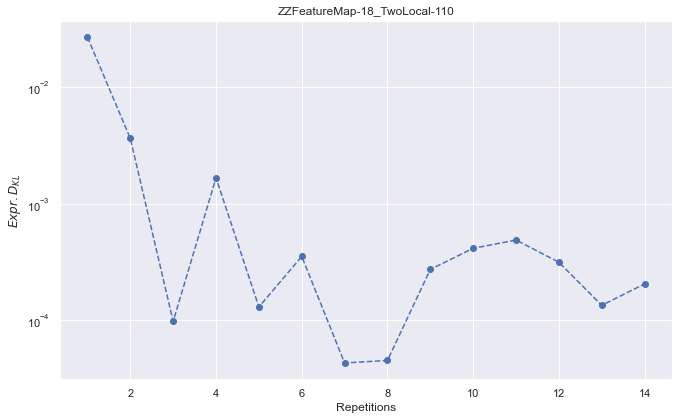

In [4]:
fig = plt.figure(figsize=(9.6, 6))
plt.title(f"{expr_metadata['fmap']}_{expr_metadata['var_ansatz']}")
plt.ylabel(r"$Expr. D_{KL}$")
plt.xlabel("Repetitions")

plt.yscale('log')
plt.plot(range(1, len(expr_data)+1),expr_data, marker = 'o', ls = '--')
plt.tight_layout()
#plt.savefig(ent_path + "/Imgs/" + idx_run + ".pdf", format = "pdf")


In [5]:
from qiskit import Aer
import qiskit as qk
from qiskit.visualization import plot_histogram
from tqdm import tqdm
from circuits import *
from run_simulations import main as run_qnn
import numpy as np
import scipy as sp
import scipy.linalg

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


## Expressibility analysys via inner products

In [59]:
# Fixing seed for reproducibility
seed = 11
np.random.seed(seed)
alternate = True
backend = 'Aer'
num_qubits = 4

# ZZFeatureMap(num_qubits, reps=1, entanglement='linear')
# TwoLocal(num_qubits, 'ry', 'cx', 'linear', reps=1, insert_barriers=True, skip_final_rotation_layer=True)
# qk.QuantumCircuit(num_qubits, name="Id", metadata={'entanglement_map': None})  # circuit9(num_qubits)
feature_map = qk.QuantumCircuit(num_qubits, name="Id", metadata={'entanglement_map': None})
var_ansatz = ring_circ(num_qubits=num_qubits)

st_list = []
reps = range(1,8)
for num_reps in reps:
    ansatz = general_qnn(num_reps, feature_map=feature_map, var_ansatz=var_ansatz, alternate=alternate, barrier=False)
    _, _, _, statevectors = run_qnn(ansatz, backend=backend, get_statevector=True)
    statevectors = np.array(statevectors)
    st_list.append(statevectors)
st_list = np.array(st_list)

SIMULATION DETAILS
num_qubits = 4
num_reps = 1
alternate = True
params = 8
fmap = Id-23850
fmap_entanglement = None
var_ansatz = ring_circ-23852
var_entanglement = circular_ish
Run 99/100
Partial tracing...
 >> Ended in 0.05634880065917969
Measured entanglement =      [0.4916 0.8058 0.5197]
Haar entanglement at bond =  [0.6004 0.9224 0.6004]
SIMULATION DETAILS
num_qubits = 4
num_reps = 2
alternate = True
params = 16
fmap = Id-24853
fmap_entanglement = None
var_ansatz = ring_circ-24856
var_entanglement = circular_ish
Run 99/100
Partial tracing...
 >> Ended in 0.05441927909851074
Measured entanglement =      [0.5578 0.8624 0.542 ]
Haar entanglement at bond =  [0.6004 0.9224 0.6004]
SIMULATION DETAILS
num_qubits = 4
num_reps = 3
alternate = True
params = 24
fmap = Id-26657
fmap_entanglement = None
var_ansatz = ring_circ-26661
var_entanglement = circular_ish
Run 99/100
Partial tracing...
 >> Ended in 0.05643200874328613
Measured entanglement =      [0.59   0.884  0.5673]
Haar entanglement 

In [60]:
def inner_products(state_list, rep):
    """
    """
    inner_p = []
    num_tests = len(st_list[0, :, 0])
    for i in range(num_tests):
        for j in range(i):
            tmp = np.abs(state_list[rep, i, :] @ np.conjugate(state_list[rep, j, :])) ** 2
            inner_p.append(tmp)
    return np.array(inner_p)

res = []
for idx, rep in enumerate(reps):
    res.append(inner_products(st_list, idx))
res = np.array(res)


In [78]:
def haar_distrib(x, n):
    return (n-1) * (1-x)**(n-2)

def haar_cumulative_inverse(x, n):
    return 1-x**(1/(n-1))

def haar_discrete(xmin, delta, n):
    return (1. - xmin)**(n-1) - (1 - xmin - delta)**(n-1)

def kl_divergence(p, q):
    #return np.sum(p * np.log(p/q))
    return sp.stats.entropy(p, q, base=np.e)

def eval_kl(fidelities, n_bins=20, num_qubits = 4):

    discrete_haar = np.array([haar_discrete(x, 1/n_bins, 2 ** num_qubits) for x in np.linspace(0, 1, n_bins + 1)[:-1]])
    y, _ = np.histogram(fidelities, range=(0, 1), bins=n_bins)
    y = y / np.sum(y)

    return kl_divergence(y, discrete_haar), y, discrete_haar

n_bins = 20
expressibility = [eval_kl(data, n_bins=n_bins, num_qubits=num_qubits)[0] for data in res]
print("Expr. D_{KL} = ", expressibility)

Expr. D_{KL} =  [0.23894636837291514, 0.05682916815639312, 0.051472007526723415, 0.050185302491971236, 0.06399279561650079, 0.05281585275504878, 0.05313986891044619]


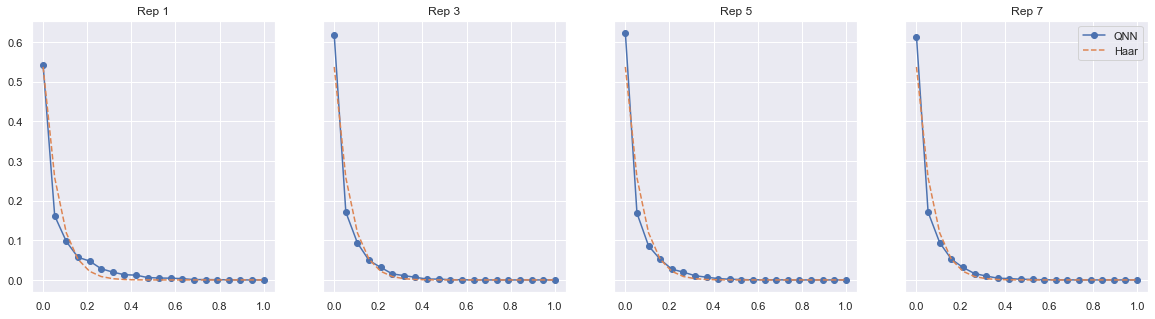

In [79]:
hist_data = [eval_kl(data, n_bins=n_bins, num_qubits=num_qubits)[1:] for data in res]
x = np.linspace(0, 1, n_bins)

num_plots = 4
reps_idx = np.array(np.linspace(0, len(hist_data)-1, num_plots), dtype=int)

fig, axs = plt.subplots(1, num_plots, figsize=(20, 5), sharey=True)
for idx, ax in zip(reps_idx, axs):
    #ax.set_xticks([0, 1])
    #ax.set_xlim([-0.01, 1])
    #ax.bar(np.linspace(0, 1, n_bins), hist_data[idx][0], label="QNN", width = 1 / n_bins, alpha = 1)
    #ax.bar(np.linspace(0, 1,  n_bins), hist_data[idx][1], label="Haar", width = 1 / n_bins, alpha = 0.5)
    ax.plot(x, hist_data[idx][0], label="QNN", marker='o')
    ax.plot(x, hist_data[idx][1], label="Haar", ls = '--')
    ax.set_title(f"Rep {idx+1}")
plt.legend()

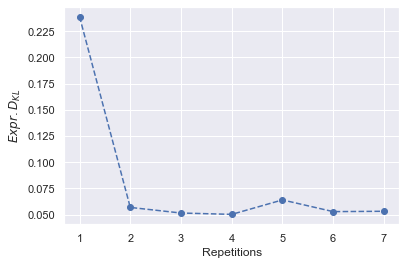

In [80]:
plt.ylabel(r"$Expr. D_{KL}$")
plt.xlabel("Repetitions")

#plt.ylim([0., 0.])
#plt.yscale('log')
plt.plot(range(1,len(expressibility)+1), expressibility, marker='o', ls='--')

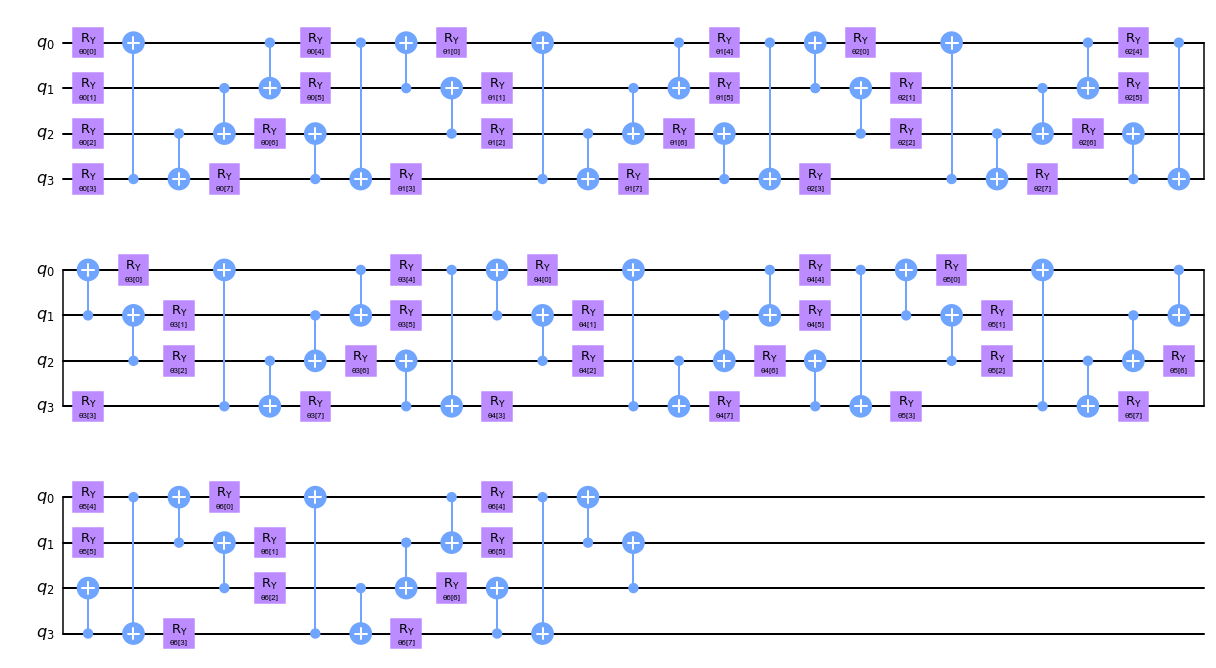

In [17]:
ansatz.draw()

## Coefficients analysis

In [62]:
probs = np.abs(st_list)**2

(array([15.10530649,  3.97508065,  2.91505915,  1.59003226,  1.32502688,
         0.53001075,  0.26500538,  0.26500538,  0.26500538,  0.26500538]),
 array([4.72469724e-06, 3.77398081e-02, 7.54748915e-02, 1.13209975e-01,
        1.50945058e-01, 1.88680142e-01, 2.26415225e-01, 2.64150308e-01,
        3.01885392e-01, 3.39620475e-01, 3.77355559e-01]))

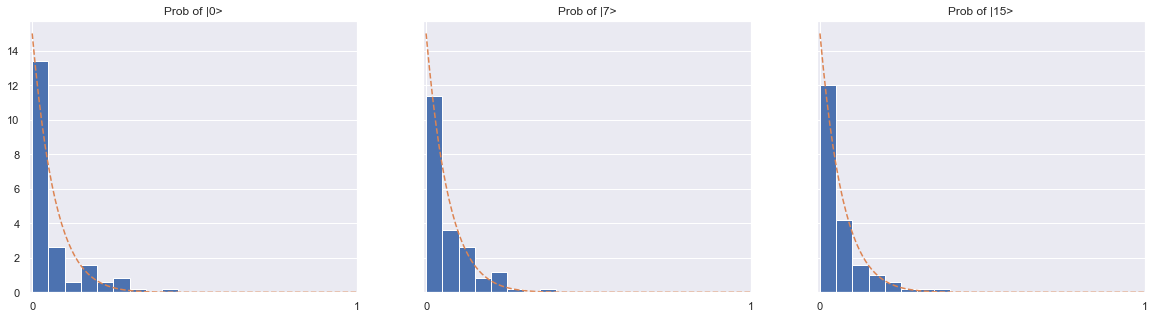

In [68]:
rep = 5
num_coeffs = 3
coeffs_idx = np.array(np.linspace(0, 2**num_qubits-1, num_coeffs), dtype = int)

fig, axs = plt.subplots(1, num_coeffs, figsize=(20, 5), sharey=True)
for idx, ax in zip(coeffs_idx, axs):
    ax.set_xticks([0, 1])
    ax.set_xlim([-0.01,1])
    ax.hist(probs[rep, :, idx], density= True, range=(0, 1), bins=20)
    ax.plot(x, (2**num_qubits - 1) * (1 - x)**(2**num_qubits-2), ls="--")
    ax.set_title(f"Prob of |{idx}>")

np.histogram(probs[rep, :, idx], density=True)


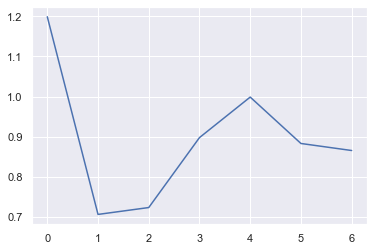

In [80]:
def haar_distrib(x, n):
    return (n-1) * (1-x)**(n-2)

def haar_cumulative_inverse(x,n):
    return 1-x**(1/(n-1))

def haar_discrete(xmin, delta, n):
    return (1. - xmin)**(n-1) - (1 - xmin - delta)**(n-1)

def kl_divergence(p,q):
    #return np.sum(p * np.log(p/q))
    return sp.stats.entropy(p, q)

def eval_kl(probs, n_bins = 20):

    discrete_haar = np.array([haar_discrete(x, 1/n_bins, dim) for x in np.linspace(0, 1, n_bins + 1)[:-1]])
    y, _ = np.histogram(probs, range=(0, 1), bins=n_bins)
    y = y / np.sum(y)

    return kl_divergence(y, discrete_haar)

kl_rep = []
for idx, r in enumerate(reps):
    #probs_r = probs[idx]
    mean = np.mean([eval_kl(probs[idx, :, i], n_bins=20) for i in range(2**num_qubits)])
    #std = np.std([eval_kl(probs_r[:, i]) for i in range(2**num_qubits)])
    kl_rep.append(eval_kl(probs[idx, :, 0], n_bins=20))

plt.plot(kl_rep)

0.235631722094664

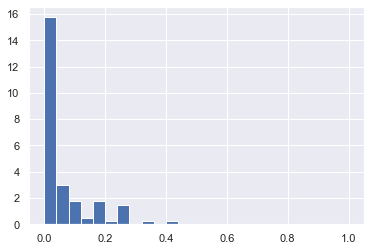

In [71]:
y = plt.hist(probs[5, :, 0], density=True, range=(0, 1), bins=25)
yh = (2**num_qubits - 1) * (1 - y[1])**(2**num_qubits-2)
sp.stats.entropy(y[0], yh[:-1])

0.899952515112006

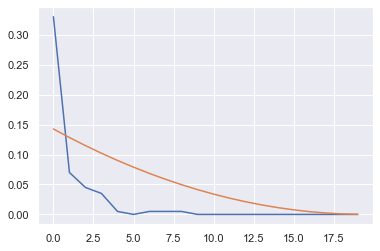

In [73]:
n_bins = 20
discrete_haar = np.array([haar_discrete(x, 1/n_bins, dim) for x in np.linspace(0, 1, n_bins + 1)[:-1]])
y, _ = np.histogram(probs[5,:,1], range=(0, 1), bins=n_bins)
y = y / np.sum(y) / 2

plt.plot(y)
#plt.hist(probs[5, :, 1], density=True, range=(0, 1), bins=n_bins)
plt.plot(discrete_haar)

sp.stats.entropy(y, discrete_haar)


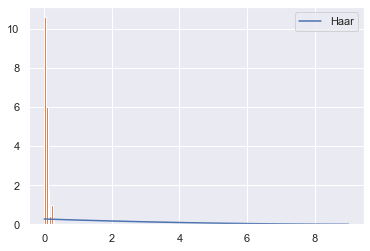

In [179]:
plt.plot(discrete_haar, label = "Haar")
plt.hist(probs[-1,:,0], density=True, range = (0,1), bins = 20)
plt.legend()

In [74]:
n_bins = 10
discrete_haar = np.array([haar_discrete(x, 1/n_bins, dim)
                         for x in np.linspace(0, 1, n_bins + 1)[:-1]])

haar_data = haar_cumulative_inverse(np.random.rand(1_000_000), 2**num_qubits)
yh, xh = np.histogram(haar_data, range=(0, 1), bins=n_bins)
yh = yh / np.sum(yh)

y, x = np.histogram(coeffs[:, 1], range=(0, 1), bins=n_bins)
y = y / np.sum(y)

kl = y * np.log(y/discrete_haar)
print(f"KL Divergemce = {np.sum(kl)}")


KL Divergemce = 0.00034318051188038113


## Haar true distribution

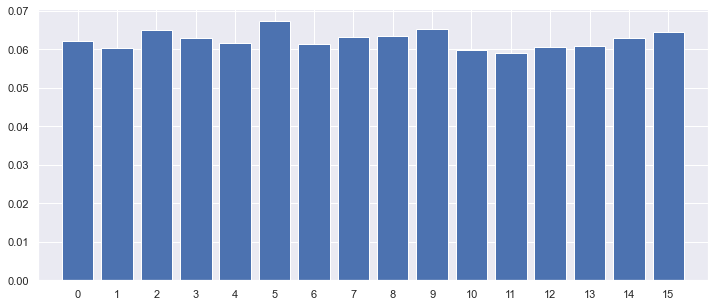

In [271]:
def random_unitary(N):
    """
    Return a Haar distributed random unitary from U(N).
    The Haar distribution is the equivalent of the uniform distribution in the space of unitary matrices (hence quantum states).

    Read this great tutorial on uniform random unitary matrices: https://pennylane.ai/qml/demos/tutorial_haar_measure.html 
    """
    Z = np.random.randn(N, N) + 1.0j * np.random.randn(N, N)
    [Q, R] = sp.linalg.qr(Z)
    D = np.diag(np.diagonal(R) / np.abs(np.diagonal(R)))
    return np.dot(Q, D)


def haar_coeffs(dim, num_tests=1000):
    """
    probs: np.array, shape: num_tests x dim
    """
    u = np.array([random_unitary(dim) for _ in range(num_tests)])
    haar_state = u @ ground_state  # equivalent to u[:,0]
    probs = np.abs(haar_state)**2
    return probs


num_tests = 10_000
n = 4
dim = 2**n
ground_state = np.array([1]+[0]*(dim-1))

coeffs = haar_coeffs(dim, num_tests)
sample = [np.random.choice(range(dim), p=probs) for probs in coeffs]

fig = plt.figure(1, figsize=(12, 5))

labels, counts = np.unique(sample, return_counts=True)
plt.bar(labels, counts / num_tests, align='center')
plt.gca().set_xticks(labels)
dx = 1
plt.xlim(-dx, (dim-1) + dx)
plt.show()


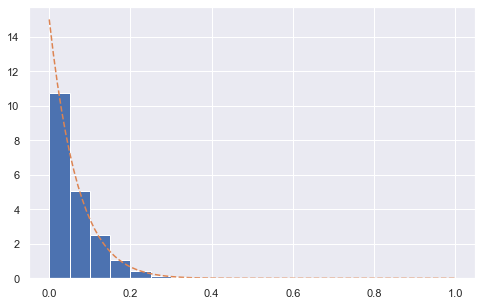

In [272]:
# Probability density of |u_ij|^2, with u_{ij} entry of Haar unitary matrix (pag. 140, The Semicircle Law, Free Random Variables and Entropy, Hiai and Petz)
x = np.linspace(0., 1., 100)
f = (dim - 1) * (1 - x)**(dim-2)

if dim < 5:
    fig, axs = plt.subplots(1, dim, figsize=(20, 5), sharey=True)
    for idx, ax in enumerate(axs):
        ax.set_xticks([0, 1])
        #ax.set_ylim([0, 1])
        ax.hist(coeffs[:, idx], density=True, bins=20, range=(0, 1))
        ax.plot(x, f, ls="--")
        ax.set_title(f"Prob of |{idx}>")

else:
    fig = plt.figure(figsize=(8, 5))
    plt.hist(coeffs[:, 0], density=True, bins=20, range=(0, 1))
    plt.plot(x, f, ls="--")
